
# 🌲 Optimized Random Forest Pipeline

This notebook trains an optimized `RandomForestClassifier` using:

- ✅ Cleaned feature processing (`dataInfo.ipynb`)
- ✅ SMOTE for class imbalance
- ✅ Optuna for hyperparameter tuning
- ✅ Stratified K-Fold cross-validation
- ✅ ROC AUC, F1, Accuracy, Precision/Recall evaluation


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)


In [23]:

# Load data and apply shared preprocessing logic
%run dataInfo.ipynb


score_cols = [f"A{i}_Score" for i in range(1, 11)]
train_df['total_score'] = train_df[score_cols].sum(axis=1)
test_df['total_score'] = test_df[score_cols].sum(axis=1)

# Normalize the total score
train_df['score_ratio'] = train_df['total_score'] / 10
test_df['score_ratio'] = test_df['total_score'] / 10

# Add interaction features
train_df['gender_result'] = train_df['gender'] * train_df['result']
train_df['age_score_ratio'] = train_df['age'] * train_df['score_ratio']
train_df['score_autism'] = train_df['total_score'] * train_df['autism']
train_df['age_jaundice'] = train_df['age'] * train_df['jaundice']
train_df['autism_result'] = train_df['autism'] * train_df['result']
train_df['gender_total_score'] = train_df['gender'] * train_df['total_score']

test_df['gender_result'] = test_df['gender'] * test_df['result']
test_df['age_score_ratio'] = test_df['age'] * test_df['score_ratio']
test_df['score_autism'] = test_df['total_score'] * test_df['autism']
test_df['age_jaundice'] = test_df['age'] * test_df['jaundice']
test_df['autism_result'] = test_df['autism'] * test_df['result']
test_df['gender_total_score'] = test_df['gender'] * test_df['total_score']


In [ ]:

# Clean via helper
cleanTrain, cleanTest = train_df, test_df
X = cleanTrain.drop(columns=["Class/ASD"])
y = cleanTrain["Class/ASD"]

X_test = cleanTest

X_train_main, X_holdout, y_train_main, y_holdout = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [25]:

def tune_random_forest_with_cv(X, y, n_trials=30):
    smote = SMOTE(random_state=42)
    imputer = SimpleImputer(strategy="mean")
    scaler = StandardScaler()
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 5, 20),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
            'random_state': 42,
            'n_jobs': -1
        }

        f1_scores = []
        for train_idx, val_idx in skf.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            X_train = imputer.fit_transform(X_train)
            X_val = imputer.transform(X_val)
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)

            X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
            model = RandomForestClassifier(**params)
            model.fit(X_resampled, y_resampled)
            y_pred = model.predict(X_val)
            f1_scores.append(f1_score(y_val, y_pred))

        return np.mean(f1_scores)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)
    print("Best hyperparameters:", study.best_params)
    return study.best_params


In [26]:

best_params = tune_random_forest_with_cv(X_train_main, y_train_main, n_trials=40)

# Final model training
imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()
X_imputed = imputer.fit_transform(X_train_main)
X_scaled = scaler.fit_transform(X_imputed)
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_scaled, y_train_main)

rf_model = RandomForestClassifier(**best_params)
rf_model.fit(X_resampled, y_resampled)


Best hyperparameters: {'n_estimators': 314, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': None}


RandomForestClassifier(max_depth=11, max_features='log2', min_samples_split=10,
                       n_estimators=314)

In [ ]:
# Step 1: Copy test
X_test = cleanTest.copy()

# Step 2: Ensure all columns in training exist in test
missing_cols = set(X.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0  # or np.nan if imputer is used

# Step 3: Reorder to match training
X_test = X_test[X.columns]

imputer.fit(X_test)
scaler.fit(X_test)

# Step 4: Preprocess
X_test = imputer.transform(X_test)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=X.columns)

# Step 5: Predict
test_predictions = rf_model.predict(X_test)
test_probabilities = rf_model.predict_proba(X_test)[:, 1]

# Step 6: Store in test set
cleanTest_with_predictions = cleanTest.copy()
cleanTest_with_predictions['Class/ASD'] = test_predictions
cleanTest_with_predictions['Probability'] = test_probabilities

F1 Score: 0.8185053380782918
ROC AUC: 0.9760311897935345
Accuracy: 0.9203125
Precision: 0.756578947368421
Recall: 0.8914728682170543


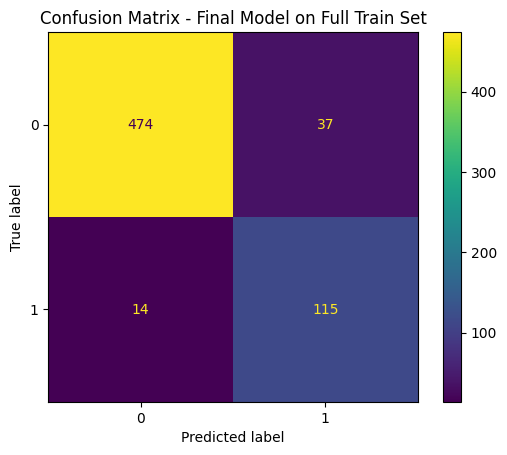

In [29]:

y_proba = rf_model.predict_proba(X_scaled)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

print("F1 Score:", f1_score(y_train_main, y_pred))
print("ROC AUC:", roc_auc_score(y_train_main, y_proba))
print("Accuracy:", accuracy_score(y_train_main, y_pred))
print("Precision:", precision_score(y_train_main, y_pred))
print("Recall:", recall_score(y_train_main, y_pred))

ConfusionMatrixDisplay.from_predictions(y_train_main, y_pred)
plt.title("Confusion Matrix - Final Model on Full Train Set")
plt.show()
